# Sentiment analysis using SpaCy

In [4]:
import spacy
from spacy.lang.de.stop_words import STOP_WORDS as STOP_WORDS_DE  #from spacy.lang.en.stop_words import STOP_WORDS as STOP_WORDS_EN
from spacy.lang.de import German                                  #from spacy.lang.en import English
from spacy_sentiws import spaCySentiWS
from textblob_de import TextBlobDE as TextBlob                    #from spacytextblob.spacytextblob import SpacyTextBlob as TextBlob
from textblob_de import PatternAnalyzer
import textacy

import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

import pandas as pd
import string
import re
from collections import Counter
import csv

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/visieu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
nlp = spacy.load("de_core_news_lg")     #nlp = spacy.load("en_core_web_sm")
language = 'german'

def get_stopwords(library="spacy"):
    if library == 'nltk':
        if language == 'german':
            stop_words = list(nltk.corpus.stopwords.words('german'))
        else:
            stop_words = list(STOP_WORDS_DE)
            
    else:
        if language == 'german':
            stop_words = list(STOP_WORDS_DE)
        else:
            stop_words = list(STOP_WORDS_EN)

    return stop_words

stop_words = get_stopwords('spacy')

### Importing data
Import data from a csv file and store it as a dataframe

In [6]:
def get_data(file_name, delimiter, encoding):
    '''
    Purpose:
        Get data from a csv file

    Inputs: 
        file_name - name of the csv file with .csv extension
        delimiter - columns separator in the csv file (in most cases, use ',')
        encoding - encoding used. Note: 'utf-8-sig' for German
    
    Output:
        A dataframe for the csv 
    '''
    df = pd.read_csv(file_name, encoding=encoding, sep=delimiter)
    df = df.dropna()
    return df

df = get_data('comments_tff-forum-147606.csv', '|', 'utf-8-sig')

### Prepocessing data
Extend the stopword list to include words specific to the application

In [7]:
def extend_stop_words(stop_words):
    '''
    Purpose:
        Extend the set of base stop words to include others words
    
    Input:
        list of stop_words
        
    Output:
        Extended list of stop words
    '''
    _stop_words = stop_words.copy()
    extension_list = ['tesla', 'tesla.com', 'teslas', 'suc', 'sucs']
    
    return _stop_words + list(set(extension_list)-set(_stop_words))

extended_stop_words = extend_stop_words(stop_words)

Preprocess data (text) removing stop words, white spaces and punctuation

In [8]:
def preprocess_text_with_spacy(text, language, stop_words):
    '''
    Purpose:
        Preprocess a piece of text eliminating stopwords, words with certain prefixes, punctuation

    Inputs: 
        text - text data
        language - language used ('English' or 'German') - primarily for the stopwords
        stop_words - list of stop words
    
    Output:
        A dataframe after preprocessing a particular column 
    '''        
    prefix = ('#','@', 'http')
    
    processed_text = text
    # Remove punctuation
    processed_text = processed_text.translate(str.maketrans('', '', string.punctuation))
    # Remove words with prefixes
    processed_text = ' '.join([word for word in processed_text.split() if not word.startswith(prefix)])
    # Remove stopwords
    processed_text = ' '.join([word.strip() for word in processed_text.split() if word.lower() not in (stop_words)])
    # Remove spaces
    processed_text = ' '.join([word.strip() for word in processed_text.split()])

    return processed_text

def preprocess_df_with_spacy(df_original, column, language, stop_words):
    '''
    Purpose:
        Preprocess the data (dataframe) eliminating stopwords, words with certain prefixes, punctuation 
        using preprocess_text_with_spacy (see below)

    Inputs: 
        df_original - dataframe of the original data
        column - name of the column where preprocessing is required
        language - language used ('English' or 'German') - primarily for the stopwords
        stop_words - list of stop words
    
    Output:
        A dataframe after preprocessing a particular column 
    '''        
    df = df_original.copy()

    # Use preprocess_text_with_spacy to process text in dataframe
    df[column] = df[column].apply(lambda x: preprocess_text_with_spacy(x, language, stop_words))
                                      
    return df

# Utility function for preprocessing tests
def get_merged_text_from_df(df, rows, column_name):
    '''
    Purpose:
        Test the output of preprocessed data (dataframe)

    Inputs: 
        df - dataframe of the preprocessed data
        column - name of the column where preprocessing is required
    
    Output:
        Return a preprocessed text string  
    '''    
    text = ''
    for i in range(len(df)):
        text += df.loc[i, column_name]
        if i > rows:
            break
            
    return text

spacy_df = preprocess_df_with_spacy(df, 'post content', 'German', extended_stop_words)

#### Data
- df - dataframe of the original data, directly from the csv
- spacy_df - dataframe which has been preprocessed i.e. no punctuation, stop words, white spaces

#### Functions
- extend_stop_words(stop_words)
- preprocess_text_with_spacy(text, language, stop_words)
- preprocess_df_with_spacy(df_original, column, language, stop_words)
- get_merged_text_from_df(df, rows, column_name)

In [9]:
merged_text = ''
for i in range(0,5):
    merged_text += df['post content'].iloc[i]
    
print(merged_text)
print('\n')

merged_text = ''
for i in range(0,5):
    merged_text += spacy_df['post content'].iloc[i]

print(merged_text)

Das Pilotprojekt startet jetzt in den Niederlanden. Tesla hat seine Webseite mit Infos gefüllt.    tesla.com – 1 Nov 21    Supercharger-Zugang für Fremdmarken - Pilotprojekt 213 Start unseres Pilotprojekts mit Supercharger-Zugang für Fremdmarken an 10 Standorten in den Niederlanden.      Wie viel kostet das Laden von Fahrzeugen, die nicht von Tesla stammen? Die Preise für Nicht-Tesla-Fahrer berücksichtigen die zusätzlichen Kosten, die anfallen, um das Laden einer Vielzahl von Fahrzeugen zu unterstützen, sowie die notwendigen Anpassungen unserer Standorte, um diese Fahrzeuge aufzunehmen. Die Tarife variieren je nach Standort und Sie können die Ladegebühren in der Tesla App abrufen. Die Ladegebühren pro kWh können mit einer Ladenetz-Mitgliedschaft gesenkt werden. Bis gespannt, welchen PReis die aufrufen.Supercharger bald offen für andere Hersteller? - Ladestationen / Tesla Supercharger - TFF Forum - Tesla Fahrer & Freunde (tff-forum.de) 48 Wurde hier schon genannt.    AirFrance:  Bis ges

In [10]:
preprocess_text_with_spacy(merged_text, 'German', extended_stop_words)

'Pilotprojekt startet Niederlanden Webseite Infos gefüllt teslacom – 1 Nov 21 SuperchargerZugang Fremdmarken Pilotprojekt 213 Start unseres Pilotprojekts SuperchargerZugang Fremdmarken 10 Standorten Niederlandenkostet Laden Fahrzeugen stammen Preise NichtTeslaFahrer berücksichtigen zusätzlichen Kosten anfallen Laden Vielzahl Fahrzeugen unterstützen notwendigen Anpassungen Standorte Fahrzeuge aufzunehmen Tarife variieren Standort Ladegebühren App abrufen Ladegebühren pro kWh LadenetzMitgliedschaft gesenkt gespannt PReis aufrufenSupercharger Hersteller Ladestationen Supercharger TFF Forum Fahrer Freunde tffforumde 48 genanntAirFrance gespannt PReis aufrufen 59ct anstatt 25ct Niederlanden twittercom Jaap Burger 17 burgerjaap It’s love now nonTesla owners can now use the Supercharger network I’m charging now at one the locations that is open for this currently only limited number only The Netherlands Deborah Bynum stetsberlin If you missed it yesterday Jaap Burger commented on BBCNews on a

In [43]:
def lemmatize_text_with_spacy(text, use_spacy_token_vectors=False):
    '''
    Purpose:
        Lemmatize a piece of text

    Inputs: 
        text - text data
    
    Output:
        Lemmatized and tokenized text 
    '''           
    processed_text = text
    tokens = nlp(processed_text)
    
    processed_text = []
    if use_spacy_token_vectors == True:
        for token in tokens:
            if token.has_vector == True:
                processed_text.append(token.lemma_)
    else:
        processed_text = [ word.lemma_ for word in tokens ]
        
    return ' '.join(processed_text)
    
def lemmatize_df_with_spacy(df_spacy, column, use_spacy_token_vectors=False):
    '''
    Purpose:
        Lemmatize a particular column of a preprocessed dataframe

    Inputs: 
        df - dataframe of the preprocessed data
        column - name of the column where lemmetization is required
    
    Output:
        Return a dataframe after lemmatization and tokenization    
    '''    
    df = df_spacy.copy()
    
    df[column] = df[column].apply(lambda x: lemmatize_text_with_spacy(x, use_spacy_token_vectors))
    
    return df

lemmatized_df = lemmatize_df_with_spacy(spacy_df, 'post content', use_spacy_token_vectors=True)

In [44]:
print(merged_text)
print('\n')
print(lemmatize_text_with_spacy(merged_text, True))
lemmatized_df['post content'].iloc[0]

Pilotprojekt startet Niederlanden Webseite Infos gefüllt teslacom – 1 Nov 21 SuperchargerZugang Fremdmarken Pilotprojekt 213 Start unseres Pilotprojekts SuperchargerZugang Fremdmarken 10 Standorten Niederlandenkostet Laden Fahrzeugen stammen Preise NichtTeslaFahrer berücksichtigen zusätzlichen Kosten anfallen Laden Vielzahl Fahrzeugen unterstützen notwendigen Anpassungen Standorte Fahrzeuge aufzunehmen Tarife variieren Standort Ladegebühren App abrufen Ladegebühren pro kWh LadenetzMitgliedschaft gesenkt gespannt PReis aufrufenSupercharger Hersteller Ladestationen Supercharger TFF Forum Fahrer Freunde tffforumde 48 genanntAirFrance gespannt PReis aufrufen 59ct anstatt 25ct Niederlanden twittercom Jaap Burger 17 burgerjaap It’s love now nonTesla owners can now use the Supercharger network I’m charging now at one the locations that is open for this currently only limited number only The Netherlands Deborah Bynum stetsberlin If you missed it yesterday Jaap Burger commented on BBCNews on an

'Pilotprojekt starten Niederlanden Webseite Infos füllen -- 1 Nov 21 Fremdmark Pilotprojekt 213 Start unser Pilotprojekt Fremdmark 10 Standort Niederlanden'

In [33]:
print(merged_text)
print('\n')
print(merged_text.split())

offenbar fängt NL Öffnung UnbenanntPNG1591×1029 210 KBEuropa starten mal abwarten losgehtmeint BjörnPreisen mal interessant Ionity Niveau befindetOuh geahnt Mal schauen entwickelt organisiert Auslastung positive Werbung Geld verkauf Strom verkaufen paar Autos


['offenbar', 'fängt', 'NL', 'Öffnung', 'UnbenanntPNG1591×1029', '210', 'KBEuropa', 'starten', 'mal', 'abwarten', 'losgehtmeint', 'BjörnPreisen', 'mal', 'interessant', 'Ionity', 'Niveau', 'befindetOuh', 'geahnt', 'Mal', 'schauen', 'entwickelt', 'organisiert', 'Auslastung', 'positive', 'Werbung', 'Geld', 'verkauf', 'Strom', 'verkaufen', 'paar', 'Autos']


In [29]:
def get_word_frequeny(lemmatized_df, column):
    corpus = ''
    for i in range(len(lemmatized_df)):
        corpus += lemmatized_df.loc[i, 'post content']
        
    corpus = corpus.split(',')
    corpus = Counter(corpus)

    corpus = {k: v for k, v in sorted(corpus.items(), key=lambda item: item[1], reverse=True)}

    return corpus

word_frequency = get_word_frequeny(lemmatized_df, 'post content')
print(word_frequency)
#pd.DataFrame.from_dict(word_frequency, orient='index').to_csv('comments_tff-forum-147606_word_frequency', encoding='utf-8-sig')

{'Pilotprojekt startet Niederlanden Webseite Infos gefüllt – 1 Nov 21 Fremdmarken Pilotprojekt 213 Start unseres Pilotprojekts Fremdmarken 10 Standorten Niederlandenkostet Laden Fahrzeugen stammen Preise berücksichtigen zusätzlichen Kosten anfallen Laden Vielzahl Fahrzeugen unterstützen notwendigen Anpassungen Standorte Fahrzeuge aufzunehmen Tarife variieren Standort App abrufen pro kWh gesenkt gespannt aufrufenSupercharger Hersteller Ladestationen Supercharger TFF Forum Fahrer Freunde 48 genanntgespannt aufrufen anstatt Niederlanden Jaap Burger 17 It ’s love now owners can now use the Supercharger network I ’ m charging now at one the locations that is open for this currently only limited number only The Netherlands Deborah If you missed it yesterday Jaap Burger on on announcement to make their available to all EV drivers and how it can of charging infrastructure at 8 min 30 video … 1 Nov 2021 5 3lediglich Probefahrt Genuss „ Mission “ dient find ich ’s kacke Netzwerk Hauptgründe kauf

In [45]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize

def get_word_frequeny_with_nltk(df_tokenized, column):
    corpus = ''
    for i in range(len(df_tokenized)):
        corpus += df_tokenized.loc[i, 'post content']
        
    corpus = corpus.split(',')
    corpus = ' '.join(corpus)
    
    fdist = FreqDist(word for word in word_tokenize(corpus))
    
    return fdist

word_frequency_with_nltk = get_word_frequeny_with_nltk(lemmatized_df, 'post content')
word_frequency_with_nltk

FreqDist({'--': 817, 'Stall': 290, 'laden': 225, 'mal': 182, 'sehen': 152, 'Auto': 125, 'Kabel': 120, 'stehen': 105, 'Supercharger': 104, 'Problem': 98, ...})

In [166]:
def get_bigrams(df_spacy, column):
    corpus = ''
    for i in range(len(df_spacy)):
        corpus += df_spacy.loc[i, 'post content']
        
    doc = nlp(corpus)
    
    return list(textacy.extract.basics.ngrams(doc, 2, min_freq=2))

bigrams = get_bigrams(spacy_df, 'post content')
bigrams
with open('comments_tff-forum-147606_bigrams.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(bigrams)

In [158]:
def get_ngrams(df_spacy, column):
    corpus = ''
    for i in range(len(df_spacy)):
        corpus += df_spacy.loc[i, 'post content']
        
    doc = nlp(corpus)
    
    return list(doc.noun_chunks)

ngrams = get_ngrams(spacy_df, 'post content')
len(ngrams)
#pd.DataFrame.from_dict(n_grams, orient='index').to_csv('comments_tff-forum-147606_ngrams', encoding='utf-8-sig')

8505

In [95]:
doc = nlp(merged_text)
ngrams = list(textacy.extract.basics.ngrams(doc, 2, min_freq=2))
print(ngrams)
print(merged_text)
print(list(doc.noun_chunks))

[1 Nov, SuperchargerZugang Fremdmarken, SuperchargerZugang Fremdmarken, gespannt PReis, gespannt PReis, PReis aufrufen, 1 Nov, gespannt PReis, PReis aufrufen]
Pilotprojekt startet Niederlanden Webseite Infos gefüllt – 1 Nov 21 SuperchargerZugang Fremdmarken  Pilotprojekt 213 Start unseres Pilotprojekts SuperchargerZugang Fremdmarken 10 Standorten Niederlandenkostet Laden Fahrzeugen stammen Preise NichtTeslaFahrer berücksichtigen zusätzlichen Kosten anfallen Laden Vielzahl Fahrzeugen unterstützen notwendigen Anpassungen Standorte Fahrzeuge aufzunehmen Tarife variieren Standort Ladegebühren App abrufen Ladegebühren pro kWh LadenetzMitgliedschaft gesenkt werden gespannt PReis aufrufenSupercharger Hersteller  Ladestationen  Supercharger  TFF Forum  Fahrer  Freunde tffforumde 48 genanntAirFrance gespannt PReis aufrufen 59ct anstatt 25ct Niederlanden twittercom Jaap Burger 17 It’s love now nonTesla owners can now use the Supercharger network I’m charging now at one the locations that is open

### Sentiment analysis
Source: 'Sentiment Analysis & Topic Modeling for Hotel Reviews' by Jianmei Wang

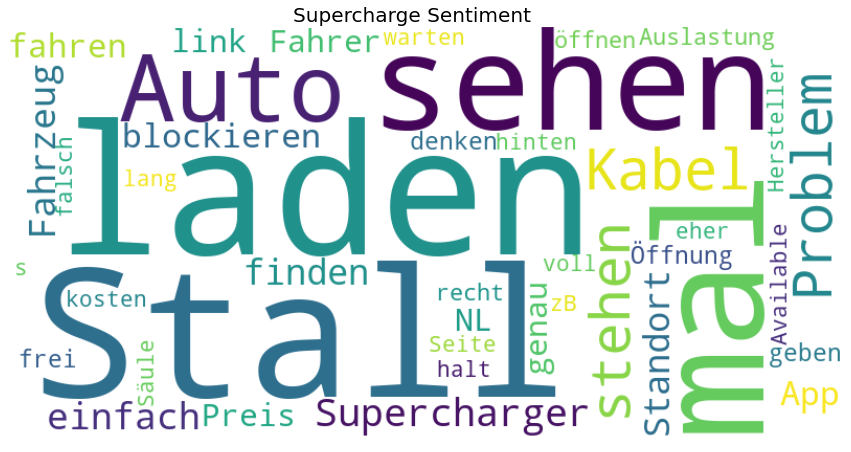

In [48]:
def show_wordcloud(df_tokenized, column_name, color, title):
    '''
    Purpose:
        Display a wordlcoud of tokens (from a column of a tokenized dataframe)

    Inputs: 
        df_tokenized - tokenized (and lemmatized) dataframe
        column_name - name of column to be put into wordcloud
        color - background color of worldcloud
        title - title of the wordcloud
    
    Outputs:
        WordCloud displaying the tokens (keywords)    
    '''
    text = df_tokenized[column_name].tolist()
    text_str = ' '.join(text)
    wordcloud = WordCloud(collocations = False, 
                          background_color = color,
                          width=800, 
                          height=400, 
                          margin=2,
                          min_font_size=20).generate(text_str)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figtext(.5,.8,title,fontsize = 20, ha='center')
    plt.show()
    
show_wordcloud(lemmatized_df, 'post content', 'white', 'Supercharge Sentiment')

/Users/visieu/opt/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


The shape of the tfidf is (1007, 372), meaning that there are 1007 post content and 372 tokens made through the filtering process.
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 4}
Model Log Likelihood Score:  -4383.488999794034
Model Perplexity:  831.81770626244


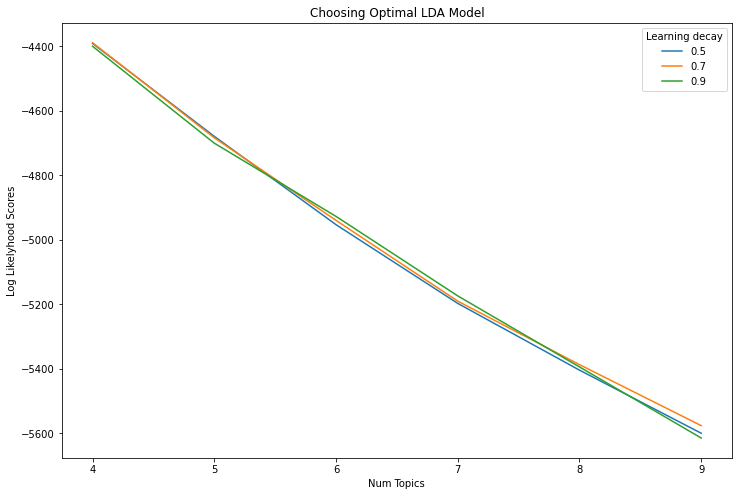

In [73]:
def search_for_best_LDA_model(df_tokenized, column_name):
    '''
    Inputs: 
        df_tokenized - tokenized (and lemmatized) dataframe
        column_name - name of column to be analysed
    
    Outputs:
        lda_tfidf - Latent Dirichlet Allocation (LDA) model
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
        A graph comparing LDA Model Performance Scores with different params
    '''
    
    #************   Step 1: Convert to document-term matrix   ************#
    
    # Initialize the vectorizer
    tf_vectorizer = CountVectorizer(
                        strip_accents = 'unicode',
                        lowercase = True,
                        token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                        ngram_range=(1,3),
                        max_df = 0.9,                        # discard words that appear in > 90% of the posts
                        min_df = 10                          # discard words that appear in < 10 posts 
                    )                            

    # Create TfidfVectorizer object
    tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
    
    # Define the corpus and convert it to a document-term matrix
    corpus = df_tokenized[column_name].tolist()
    dtm_tfidf = tfidf_vectorizer.fit_transform(corpus)
    print("The shape of the tfidf is {}, meaning that there are {} {} and {} tokens made through the filtering process.".\
              format(dtm_tfidf.shape,dtm_tfidf.shape[0], column_name, dtm_tfidf.shape[1]))
    
        
    #*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

    # Define Search Param
    search_params = {'n_components': [4, 5, 6, 7, 8], 
                     'learning_decay': [.5, .7, .9]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(dtm_tfidf)

    #*****  Step 3: Output the optimal lda model and its parameters  *****#

    # Best Model
    best_lda_model = model.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model.best_params_)

    # Log Likelihood Score: Higher the better
    print("Model Log Likelihood Score: ", model.best_score_)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))

    
    #***********   Step 4: Compare LDA Model Performance Scores   ***********#

    #Get Log Likelyhoods from Grid Search Output
    gscore=model.fit(dtm_tfidf).cv_results_
    n_topics = [4, 5, 6, 7, 8]

    log_likelyhoods_5 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.5]
    log_likelyhoods_7 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.7]
    log_likelyhoods_9 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.9]

    # Show graph
    plt.figure(figsize=(12, 8))
    plt.plot(n_topics, log_likelyhoods_5, label='0.5')
    plt.plot(n_topics, log_likelyhoods_7, label='0.7')
    plt.plot(n_topics, log_likelyhoods_9, label='0.9')
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelyhood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    
    return best_lda_model, dtm_tfidf, tfidf_vectorizer

best_lda_model, dtm_tfidf, tfidf_vectorizer = search_for_best_LDA_model(lemmatized_df, 'post content')

In [76]:
def display_topics(model, feature_names, n_top_words):
    '''
    INPUTS:
        model - the model that was created
        feature_names - name of the topic as column
        n_top_words - number of top words to display
        
    OUTPUTS:
        a dataframe that contains the topics that were created and the weights of each token
    '''
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


display_topics(best_lda_model, tfidf_vectorizer.get_feature_names_out(), n_top_words = 10) 

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,abo,13.8,kabel,16.1,thema,14.9,stall,39.8
1,warten,13.7,mal,12.9,supercharger,12.4,blockieren,20.3
2,offnung,13.6,problem,12.2,ccs,11.4,laden,17.7
3,laden,12.4,stehen,11.3,app,11.3,sehen,14.0
4,preis,10.2,stecker,10.9,deutschland,11.3,fahrzeug,13.0
5,fahren,10.1,laden,10.3,hoch,9.9,falsch,12.6
6,mal,9.5,lang,10.2,wissen,9.7,mal,12.4
7,meinen,8.9,einfach,9.1,niederlanden,8.8,seite,12.1
8,stimmen,8.2,auto,9.1,pro,8.4,finden,11.1
9,the,7.8,app,8.3,laden,8.2,frei,11.0


In [77]:
# Topic Modelling Visualization for the Negative Reviews
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

/Users/visieu/opt/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/visieu/opt/miniconda3/envs/nlp/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.129003  0.056639       1        1  29.492019
1     -0.067858 -0.040949       2        1  25.130310
0      0.072183 -0.123520       3        1  22.724871
2      0.124677  0.107830       4        1  22.652800, topic_info=           Term       Freq      Total Category  logprob  loglift
308       stall  41.000000  41.000000  Default  30.0000  30.0000
54   blockieren  18.000000  18.000000  Default  29.0000  29.0000
332       thema  13.000000  13.000000  Default  28.0000  28.0000
0           abo  12.000000  12.000000  Default  27.0000  27.0000
354      warten  13.000000  13.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
187       laden   7.272757  42.431450   Topic4  -4.4005  -0.2789
217         mal   5.643810  36.020104   Topic4  -4.6541  -0.3686
311    standort   4.840572  16.955217   Topic4  -4.8076   0.2313
153  hersteller   4.587810  10.319741   Topic4  -4.8612   0.6742
314      stehen   4.781896  24.333798   Topic4  -4.8198  -0.1421

[229 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         3  0.929926         abo
4         1  0.110584     aktuell
4         2  0.221169     aktuell
4         3  0.110584     aktuell
4         4  0.663506     aktuell
...     ...       ...         ...
363       3  0.208276      zahlen
369       1  0.727690    zulassen
370       1  0.242165   zumindest
370       4  0.726495   zumindest
371       1  0.770571  zusatzlich

[351 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [118]:
def texblob_sentiment_scores(paragraph):
    doc = nlp(paragraph)
    scores = []
    for sents in doc.sents:
        blob = TextBlob(sents.text)
        score = blob.sentiment[0]
        scores.append(score)
        print(sents.text, round(score,2))
    
    return scores
        
def sentiws_sentiment_scores(paragraph):
    doc = nlp(paragraph)
    scores = []
    for token in doc:
        #print(token.text, token._.sentiws)
        if token._.sentiws is not None:
            print(token.text, token._.sentiws)
    
    return scores
    
#paragraph="Das Pilotprojekt startet jetzt in den Niederlanden. Tesla hat seine Webseite mit Infos gefüllt. tesla.com – 1 Nov 21. Supercharger-Zugang für Fremdmarken - Pilotprojekt 213 Start unseres Pilotprojekts mit Supercharger-Zugang für Fremdmarken an 10 Standorten in den Niederlanden. Wie viel kostet das Laden von Fahrzeugen, die nicht von Tesla stammen? Die Preise für Nicht-Tesla-Fahrer berücksichtigen die zusätzlichen Kosten, die anfallen, um das Laden einer Vielzahl von Fahrzeugen zu unterstützen, sowie die notwendigen Anpassungen unserer Standorte, um diese Fahrzeuge aufzunehmen."
paragraph="@Pfalz-Markus Es geht eher um genau solche Situationen und das Verhalten vieler.  Früher waren wir nur S und X Fahrer (nein, wir sind nichts besseres) da hat jeder auf jeden etwas geachtet, das man nicht direkt neben einen steht, hat sich ausgetauscht und"
scores = texblob_sentiment_scores(paragraph)
print('Average =',sum(scores)/len(scores))
sentiws_sentiment_scores(paragraph)

@Pfalz-Markus 0.0
Es geht eher um genau solche Situationen und das Verhalten vieler.   -1.0
Früher waren wir nur S und X Fahrer (nein, wir sind nichts besseres) da hat jeder auf jeden etwas geachtet, das man nicht direkt neben einen steht, hat sich ausgetauscht und 0.33
Average = -0.225
besseres 0.3716


[]

## End

In [99]:
#nlp.add_pipe('sentiws', config={'sentiws_path': 'data/SentiWS_v2'})
doc = nlp('Ist denn schon etwas zu den Preisen bekannt? Würde mal interessant sein ob man sich da auf Ionity Niveau befindet.')
for token in doc:
    print('{}, {}, {}'.format(token.text, token._.sentiws, token.pos_))

Ist, None, AUX
denn, None, ADV
schon, None, ADV
etwas, None, PRON
zu, None, ADP
den, None, DET
Preisen, None, NOUN
bekannt, None, ADV
?, None, PUNCT
Würde, None, AUX
mal, None, ADV
interessant, None, ADV
sein, None, AUX
ob, None, SCONJ
man, None, PRON
sich, None, PRON
da, None, ADV
auf, None, ADP
Ionity, None, PROPN
Niveau, None, NOUN
befindet, None, VERB
., None, PUNCT


In [91]:
def assess_sentiment(df_tokenized, column):
    df = df_tokenized.copy()
    # Create new column to store sentiment
    df['polarity score'] = ['']*len(df)
    df['subjectivity score'] = ['']*len(df)
    
    for i, row in df.iterrows():
        blob = TextBlob(df.at[i,column])
        
        df.at[i, 'polarity score'] = round(blob.sentiment[0],2)
        df.at[i, 'subjectivity score'] = round(blob.sentiment[1],2)
            
    return df

df_sentiment = assess_sentiment(df, 'post content')
df_sentiment.to_csv('comments_tff-forum-147606_sentiment', encoding='utf-8-sig')